# DSA4212 Assignment 1

## Constants

In [1]:
# Random seed
TRAIN_SEED = 4212

# Resized image size
IMAGE_SIZE = 32

# Augment until there's at least this many training dataset
AUGMENT_LIMIT = 50000

# Whether to print fit progress
VERBOSE = 1

# Whether to calculate validation accuracy for every epoch
CALC_VALID = 0

# Time limit for model training
TIME_LIMIT = 120

# Reshuffle post-augmentation?
RESHUFFLE = 0

# Filenames
TRAIN_FP = "assignment_1_train.npz"
VAL_FP = "assignment_1_test.npz"

## Imports
No JAX here :)
We'll use NumPy, Keras, Tensorflow, and PyTorch

In [2]:
!pip install -q -U tensorflow-addons

In [3]:
import numpy as np
from tqdm.auto import tqdm
import pylab as plt
import copy
import time
import cv2 as cv
from random import sample
import random

from google.colab import drive
import tensorflow_addons as tfa

import tensorflow as tf
from tensorflow.keras import Input, Model, callbacks, datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dropout, Dense, Resizing, Rescaling, RandomCrop, RandomFlip, Activation, BatchNormalization, DepthwiseConv2D, Add, GlobalAvgPool2D
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay

import keras
from keras.utils import np_utils, to_categorical
from keras import regularizers

import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid

In [4]:
!nvidia-smi -L
!lscpu |grep 'Model name'
!free -h --si | awk  '/Mem:/{print $2}'

GPU 0: Tesla T4 (UUID: GPU-7bda19ce-e583-b5a4-ea51-d7b57e843de5)
Model name:                      Intel(R) Xeon(R) CPU @ 2.30GHz
12G


## Utilities
All common functions to be used in the future

In [5]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

def clear_tf():
  tf.keras.backend.clear_session()

In [6]:
def train_and_evaluate(model, batch_size, epochs, optimizer):
  set_seed(TRAIN_SEED)
  clear_tf()

  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  history = model.fit(X_train, Y_train,
                      validation_data=(X_val, Y_val) if CALC_VALID else None,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=VERBOSE,
                      callbacks=[tfa.callbacks.TimeStopping(seconds=TIME_LIMIT, verbose=VERBOSE)])
  plt.plot(history.history['accuracy'])
  if CALC_VALID: plt.plot(history.history['val_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train'] + ['valid']*int(CALC_VALID), loc='upper left')
  plt.show()
  print('Validation accuracy:', model.evaluate(X_val, Y_val)[1])

### PyTorch-specific

In [7]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [8]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}, last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [9]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [10]:
def fit_one_cycle(max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    t = time.time()

    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=100, 
                                                steps_per_epoch=len(train_loader))
    
    epoch = 1
    cyc = 0
    while True:
        # Training Phase
        t_elapsed = time.time() - t
        print('Time elapsed:', t_elapsed)
        if t_elapsed >= TIME_LIMIT-cyc: return
        
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        if val_loader:
          result = evaluate(model, val_loader)
        else:
          result = evaluate(model, train_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        epoch += 1
        if cyc == 0: cyc = time.time() - t

In [11]:
def train_pytorch(model, max_lr, grad_clip, train_split=1, batch_size=400, weight_decay=1e-4, opt_func=torch.optim.Adam):
    n = int(train_split*len(X_train))
    train_ds = torch.utils.data.TensorDataset(torch.tensor(X_train[:n].transpose(0, 3, 1, 2)), torch.tensor(Y_train_sparse[:n]))
    if train_split != 1: valid_ds = torch.utils.data.TensorDataset(torch.tensor(X_train[n:].transpose(0, 3, 1, 2)), torch.tensor(Y_train_sparse[n:]))
    test_ds = torch.utils.data.TensorDataset(torch.tensor(X_val.transpose(0, 3, 1, 2)), torch.tensor(Y_val_sparse))

    # PyTorch data loaders
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    if train_split != 1: valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)
    test_dl = DataLoader(test_ds, batch_size*2, num_workers=2, pin_memory=True)

    device = get_default_device()
    train_dl = DeviceDataLoader(train_dl, device)
    if train_split != 1: valid_dl = DeviceDataLoader(valid_dl, device)
    test_dl = DeviceDataLoader(test_dl, device)

    # Grid search
    set_seed(TRAIN_SEED)
    model = to_device(model, device)
    if train_split == 1: valid_dl = None
    fit_one_cycle(max_lr, model, train_dl, valid_dl,
                  weight_decay=weight_decay,
                  grad_clip=grad_clip,
                  opt_func=opt_func)
    print('Train accuracy:', evaluate(model, train_dl)['val_acc'])
    if train_split != 1: print('Valid accuracy:', evaluate(model, valid_dl)['val_acc'])
    print('**Test accuracy:', evaluate(model, test_dl)['val_acc'])

## Load data

Loads to `X_train, Y_train, X_val, Y_val`

In [12]:
drive.mount("/content/drive")
%cd /content/drive/MyDrive/dataset/DSA4212/assignment_1/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/dataset/DSA4212/assignment_1


In [13]:
class_names = ["fish", "dog", "device", "chainsaw", "church", "horn", "truck", "petrol", "golf", "parachute"]

data_train = np.load(TRAIN_FP)
data_val = np.load(VAL_FP)

X_train = data_train["img"].astype(np.float32) / 255. # set pixel intensities to [0,1]
X_val = data_val["img"].astype(np.float32) / 255.
Y_train = to_categorical(data_train["label"].astype(int))
Y_val = to_categorical(data_val["label"].astype(int))

In [14]:
# Shuffle training dataset
set_seed(TRAIN_SEED)
indices_shuffled = np.arange(len(X_train))
np.random.shuffle(indices_shuffled)
X_train = X_train[indices_shuffled]
Y_train = Y_train[indices_shuffled]

# Shuffle validation dataset
set_seed(TRAIN_SEED)
indices_shuffled = np.arange(len(X_val))
np.random.shuffle(indices_shuffled)
X_val = X_val[indices_shuffled]
Y_val = Y_val[indices_shuffled]

## Load data: sanity check

In [15]:
# Training dataset
X_train.shape, Y_train.shape

((9296, 128, 128, 3), (9296, 10))

In [16]:
# Validation dataset
X_val.shape, Y_val.shape

((3856, 128, 128, 3), (3856, 10))

# Data Preprocessing

## Resize Images
128x128 is too big of an image and by resizing to a smaller size, we can still have the important features of the images while saving more memory in Colab.

In [17]:
# In case the original is needed
X_train_ori, X_val_ori = X_train, X_val

In [18]:
X_train_resized, X_val_resized = [], []
for i in X_train: X_train_resized.append(cv.resize(i, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv.INTER_AREA))
for i in X_val:   X_val_resized.append(cv.resize(i, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv.INTER_AREA))

X_train = np.array(X_train_resized)
X_val = np.array(X_val_resized)

## Resize images: sanity check

In [19]:
X_train.shape, X_val.shape

((9296, 32, 32, 3), (3856, 32, 32, 3))

## Augment data
With 9296 images, overfitting can still happen very easily. This technique should reduce overfitting.

In [20]:
X_train_resized = X_train
X_train_resized.shape

(9296, 32, 32, 3)

In [21]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.12,
    height_shift_range=0.12,
    horizontal_flip=True,
    shear_range=0.1,        
    zoom_range=0.1,
)

datagen.fit(X_train_resized)

In [22]:
X_train_preaug = X_train
Y_train_preaug = Y_train
for X, Y in datagen.flow(X_train, Y_train, batch_size=512):
  X_train = np.concatenate([X_train, X])
  Y_train = np.concatenate([Y_train, Y])
  if Y_train.shape[0] > AUGMENT_LIMIT: break
Y_train_sparse = np.where(Y_train == 1)[1]
Y_val_sparse = np.where(Y_val == 1)[1]

## Augment data: sanity check

In [23]:
X_train_preaug.shape, Y_train_preaug.shape

((9296, 32, 32, 3), (9296, 10))

In [24]:
# Should be different than above!
X_train.shape, Y_train.shape

((50064, 32, 32, 3), (50064, 10))

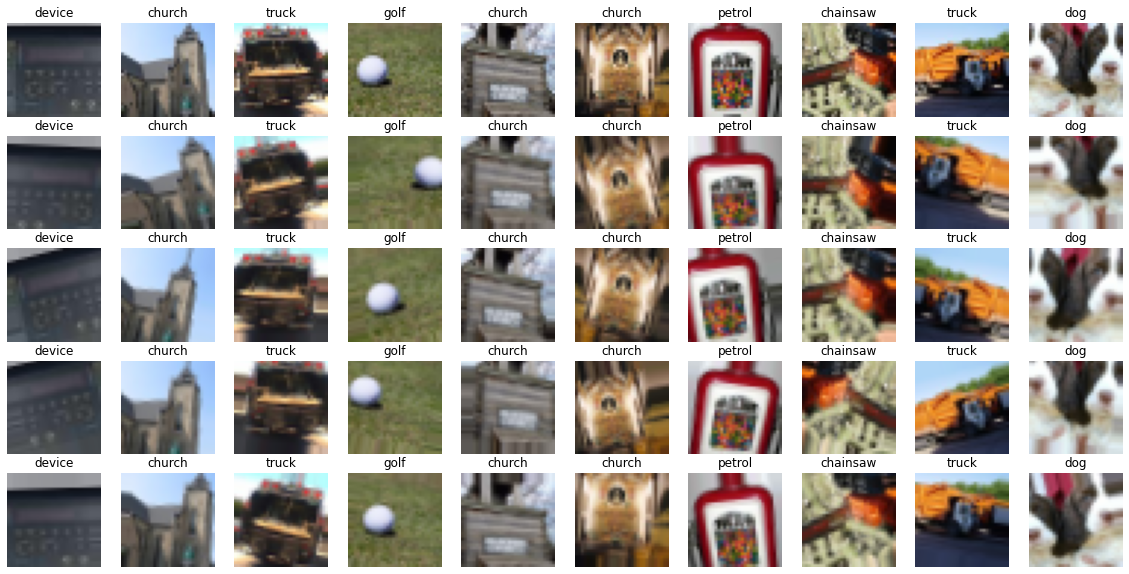

In [25]:
plt.figure(figsize=(10*2,5*2))
for k in range(10):
  plt.subplot(5,10,k+1)
  plt.axis("off")
  plt.imshow(X_train[k])
  plt.title(class_names[np.where(Y_train[k] == 1)[0][0]])
  aug = datagen.flow(X_train[k:k+1], batch_size=1)
  for m in range(4):
    plt.subplot(5,10,k+11+10*m)
    plt.axis("off")
    plt.imshow(next(aug)[0].astype('float32'))
    plt.title(class_names[np.where(Y_train[k] == 1)[0][0]])

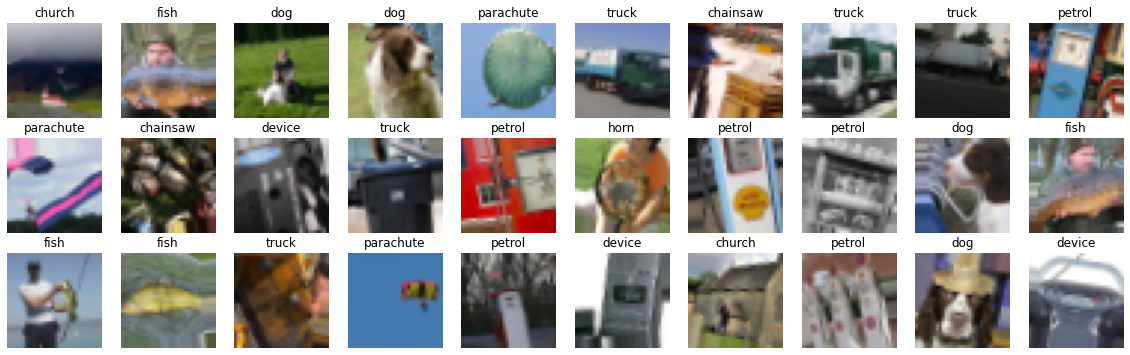

In [26]:
plt.figure(figsize=(10*2,3*2))
for k in range(3*10):
  index = np.random.randint(low=len(X_train_ori), high=len(X_train))
  plt.subplot(3,10,k+1)
  plt.axis("off")
  plt.imshow(X_train[index,:,:,:])
  plt.title(class_names[np.where(Y_train[index] == 1)[0][0]])

## Check data distribution
In case we have an imbalanced dataset...

### Pre-augment

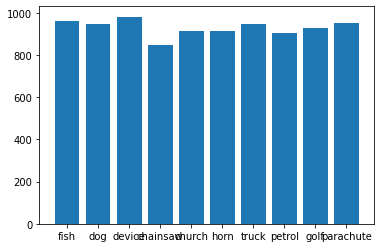

In [27]:
labels = np.where(Y_train_preaug == 1)[1]
plt.bar(class_names, list(map(lambda x: np.count_nonzero(labels == x), range(10))))
plt.show()

### Post-augment

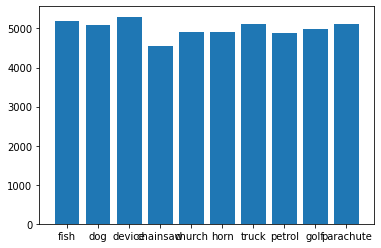

In [28]:
labels = np.where(Y_train == 1)[1]
plt.bar(class_names, list(map(lambda x: np.count_nonzero(labels == x), range(10))))
plt.show()

# CNN Models
General form to train: `ModelClass().train(batch_size, epochs, optimizer)`

## Base Class

In [29]:
# Remove unused variables to save some memory
try: del X_train_ori, X_val_ori, X_train_preaug, Y_train_preaug, X_train_resized
except: pass

if RESHUFFLE:
  # Reshuffle training dataset
  set_seed(TRAIN_SEED)
  indices_shuffled = np.arange(len(X_train))
  np.random.shuffle(indices_shuffled)
  X_train = X_train[indices_shuffled]
  Y_train = Y_train[indices_shuffled]

  # Reshuffle validation dataset
  set_seed(TRAIN_SEED)
  indices_shuffled = np.arange(len(X_val))
  np.random.shuffle(indices_shuffled)
  X_val = X_val[indices_shuffled]
  Y_val = Y_val[indices_shuffled]

In [30]:
class DSA4212Model:
  def __init__(self, model):
    self.model = model

  def train(self, batch_size, epochs, optimizer):
    train_and_evaluate(self.model, batch_size, epochs, optimizer)

## 2-Block VGG
https://www.kaggle.com/code/amyjang/tensorflow-cifar10-cnn-tutorial

### Architecture

In [31]:
class VGG2(DSA4212Model):
  def __init__(self):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(10, activation='softmax'))
    
    super().__init__(model)

### Grid search

Epoch 1/20
1565/1565 [==============================] - 16s 7ms/step - loss: 1.5982 - accuracy: 0.4552
Epoch 2/20
1565/1565 [==============================] - 11s 7ms/step - loss: 1.1491 - accuracy: 0.6208
Epoch 3/20
1565/1565 [==============================] - 11s 7ms/step - loss: 1.0024 - accuracy: 0.6706
Epoch 4/20
1565/1565 [==============================] - 11s 7ms/step - loss: 0.9131 - accuracy: 0.6980
Epoch 5/20
1565/1565 [==============================] - 11s 7ms/step - loss: 0.8445 - accuracy: 0.7209
Epoch 6/20
1565/1565 [==============================] - 11s 7ms/step - loss: 0.7824 - accuracy: 0.7416
Epoch 7/20
1565/1565 [==============================] - 10s 7ms/step - loss: 0.7336 - accuracy: 0.7551
Epoch 8/20
1565/1565 [==============================] - 11s 7ms/step - loss: 0.6893 - accuracy: 0.7688
Epoch 9/20
1565/1565 [==============================] - 11s 7ms/step - loss: 0.6513 - accuracy: 0.7810
Epoch 10/20
1565/1565 [==============================] - 11s 7ms/step - l

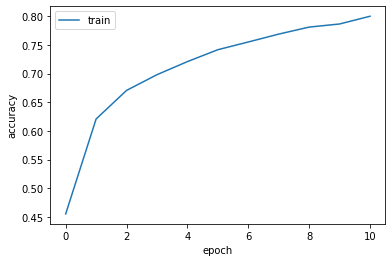

121/121 [==============================] - 1s 4ms/step - loss: 1.0405 - accuracy: 0.7002
Validation accuracy: 0.7002074718475342


In [32]:
VGG2().train(
    batch_size=32,
    epochs=20,
    optimizer=Adam(learning_rate=1e-3))

Epoch 1/40
783/783 [==============================] - 9s 9ms/step - loss: 1.6099 - accuracy: 0.4483
Epoch 2/40
783/783 [==============================] - 7s 9ms/step - loss: 1.1494 - accuracy: 0.6237
Epoch 3/40
783/783 [==============================] - 7s 9ms/step - loss: 0.9962 - accuracy: 0.6726
Epoch 4/40
783/783 [==============================] - 6s 8ms/step - loss: 0.8849 - accuracy: 0.7071
Epoch 5/40
783/783 [==============================] - 7s 9ms/step - loss: 0.7974 - accuracy: 0.7352
Epoch 6/40
783/783 [==============================] - 6s 8ms/step - loss: 0.7339 - accuracy: 0.7544
Epoch 7/40
783/783 [==============================] - 7s 9ms/step - loss: 0.6864 - accuracy: 0.7707
Epoch 8/40
783/783 [==============================] - 7s 8ms/step - loss: 0.6304 - accuracy: 0.7876
Epoch 9/40
783/783 [==============================] - 7s 9ms/step - loss: 0.5863 - accuracy: 0.8022
Epoch 10/40
783/783 [==============================] - 6s 8ms/step - loss: 0.5511 - accuracy: 0.8144

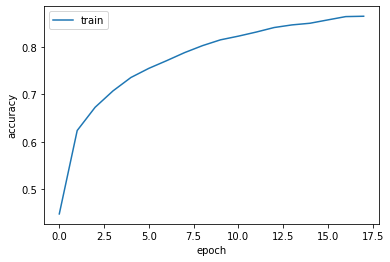

121/121 [==============================] - 1s 4ms/step - loss: 1.0785 - accuracy: 0.7365
Validation accuracy: 0.7365145087242126


In [33]:
VGG2().train(
    batch_size=64,
    epochs=40,
    optimizer=Adam(learning_rate=1e-3))

Epoch 1/40
783/783 [==============================] - 10s 9ms/step - loss: 1.7903 - accuracy: 0.3772
Epoch 2/40
783/783 [==============================] - 7s 9ms/step - loss: 1.3232 - accuracy: 0.5628
Epoch 3/40
783/783 [==============================] - 7s 9ms/step - loss: 1.1645 - accuracy: 0.6155
Epoch 4/40
783/783 [==============================] - 7s 8ms/step - loss: 1.0855 - accuracy: 0.6412
Epoch 5/40
783/783 [==============================] - 7s 9ms/step - loss: 1.0197 - accuracy: 0.6632
Epoch 6/40
783/783 [==============================] - 6s 8ms/step - loss: 0.9641 - accuracy: 0.6800
Epoch 7/40
783/783 [==============================] - 7s 9ms/step - loss: 0.9347 - accuracy: 0.6920
Epoch 8/40
783/783 [==============================] - 6s 8ms/step - loss: 0.8999 - accuracy: 0.7001
Epoch 9/40
783/783 [==============================] - 7s 9ms/step - loss: 0.8731 - accuracy: 0.7094
Epoch 10/40
783/783 [==============================] - 6s 8ms/step - loss: 0.8471 - accuracy: 0.718

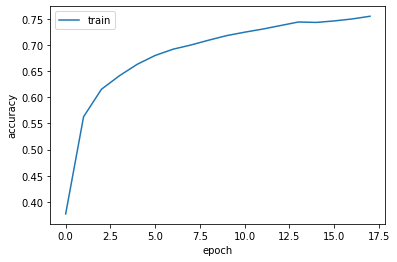

121/121 [==============================] - 1s 4ms/step - loss: 1.0699 - accuracy: 0.6927
Validation accuracy: 0.6926867365837097


In [34]:
VGG2().train(
    batch_size=64,
    epochs=40,
    optimizer=Adam(learning_rate=2e-3))

Epoch 1/40
783/783 [==============================] - 10s 9ms/step - loss: 1.7021 - accuracy: 0.4181
Epoch 2/40
783/783 [==============================] - 7s 8ms/step - loss: 1.2533 - accuracy: 0.5901
Epoch 3/40
783/783 [==============================] - 7s 9ms/step - loss: 1.0695 - accuracy: 0.6502
Epoch 4/40
783/783 [==============================] - 7s 8ms/step - loss: 0.9491 - accuracy: 0.6907
Epoch 5/40
783/783 [==============================] - 7s 9ms/step - loss: 0.8656 - accuracy: 0.7176
Epoch 6/40
783/783 [==============================] - 8s 10ms/step - loss: 0.8024 - accuracy: 0.7365
Epoch 7/40
783/783 [==============================] - 7s 9ms/step - loss: 0.7541 - accuracy: 0.7539
Epoch 8/40
783/783 [==============================] - 7s 9ms/step - loss: 0.7136 - accuracy: 0.7661
Epoch 9/40
783/783 [==============================] - 7s 9ms/step - loss: 0.6812 - accuracy: 0.7794
Epoch 10/40
783/783 [==============================] - 7s 9ms/step - loss: 0.6517 - accuracy: 0.78

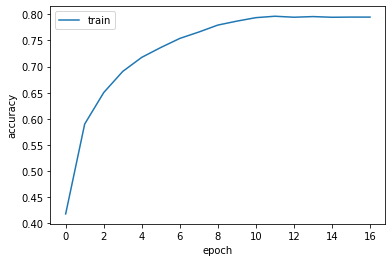

121/121 [==============================] - 1s 5ms/step - loss: 1.5726 - accuracy: 0.6608
Validation accuracy: 0.660788357257843


In [35]:
VGG2().train(
    batch_size=64,
    epochs=40,
    optimizer=RMSprop(learning_rate=1e-3, weight_decay=1e-5))

Epoch 1/40
783/783 [==============================] - 9s 8ms/step - loss: 1.7288 - accuracy: 0.4087
Epoch 2/40
783/783 [==============================] - 7s 9ms/step - loss: 1.2539 - accuracy: 0.5907
Epoch 3/40
783/783 [==============================] - 6s 8ms/step - loss: 1.0593 - accuracy: 0.6559
Epoch 4/40
783/783 [==============================] - 7s 9ms/step - loss: 0.9399 - accuracy: 0.6934
Epoch 5/40
783/783 [==============================] - 6s 8ms/step - loss: 0.8575 - accuracy: 0.7194
Epoch 6/40
783/783 [==============================] - 7s 9ms/step - loss: 0.7964 - accuracy: 0.7404
Epoch 7/40
783/783 [==============================] - 7s 9ms/step - loss: 0.7512 - accuracy: 0.7543
Epoch 8/40
783/783 [==============================] - 7s 9ms/step - loss: 0.7245 - accuracy: 0.7652
Epoch 9/40
783/783 [==============================] - 7s 9ms/step - loss: 0.7028 - accuracy: 0.7757
Epoch 10/40
783/783 [==============================] - 7s 10ms/step - loss: 0.6988 - accuracy: 0.775

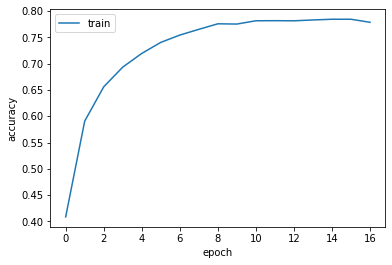

121/121 [==============================] - 1s 4ms/step - loss: 1.0383 - accuracy: 0.7254
Validation accuracy: 0.7253630757331848


In [36]:
VGG2().train(
    batch_size=64,
    epochs=40,
    optimizer=RMSprop(learning_rate=1e-3, weight_decay=1e-6))

## 3-Block VGG
https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

### Architecture

In [37]:
class VGG3(DSA4212Model):
  def __init__(self):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(10, activation='softmax'))
    
    super().__init__(model)

### Grid search

Epoch 1/10
1565/1565 [==============================] - 24s 11ms/step - loss: 1.5096 - accuracy: 0.5060
Epoch 2/10
1565/1565 [==============================] - 17s 11ms/step - loss: 1.0624 - accuracy: 0.6572
Epoch 3/10
1565/1565 [==============================] - 18s 12ms/step - loss: 0.8969 - accuracy: 0.7096
Epoch 4/10
1565/1565 [==============================] - 19s 12ms/step - loss: 0.7767 - accuracy: 0.7505
Epoch 5/10
1565/1565 [==============================] - 17s 11ms/step - loss: 0.6871 - accuracy: 0.7766
Epoch 6/10
1565/1565 [==============================] - 17s 11ms/step - loss: 0.6152 - accuracy: 0.8015
Epoch 7/10
1565/1565 [==============================] - 18s 11ms/step - loss: 0.5480 - accuracy: 0.8200
Timed stopping at epoch 7 after training for 0:02:00


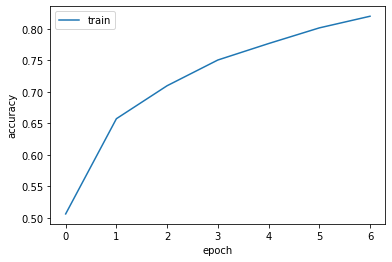

121/121 [==============================] - 1s 4ms/step - loss: 0.7988 - accuracy: 0.7674
Validation accuracy: 0.7673755288124084


In [38]:
VGG3().train(
    batch_size=32,
    epochs=10,
    optimizer=Adam(
        learning_rate=ExponentialDecay(
            initial_learning_rate=2e-3,
            decay_steps=1000,
            decay_rate=0.9)))

Epoch 1/20
392/392 [==============================] - 14s 22ms/step - loss: 1.6034 - accuracy: 0.4856
Epoch 2/20
392/392 [==============================] - 9s 22ms/step - loss: 1.0875 - accuracy: 0.6443
Epoch 3/20
392/392 [==============================] - 8s 22ms/step - loss: 0.9169 - accuracy: 0.7029
Epoch 4/20
392/392 [==============================] - 9s 22ms/step - loss: 0.8094 - accuracy: 0.7369
Epoch 5/20
392/392 [==============================] - 9s 22ms/step - loss: 0.7167 - accuracy: 0.7673
Epoch 6/20
392/392 [==============================] - 9s 22ms/step - loss: 0.6492 - accuracy: 0.7896
Epoch 7/20
392/392 [==============================] - 9s 23ms/step - loss: 0.5990 - accuracy: 0.8061
Epoch 8/20
392/392 [==============================] - 9s 22ms/step - loss: 0.5341 - accuracy: 0.8248
Epoch 9/20
392/392 [==============================] - 9s 22ms/step - loss: 0.4966 - accuracy: 0.8355
Epoch 10/20
392/392 [==============================] - 9s 22ms/step - loss: 0.4521 - accur

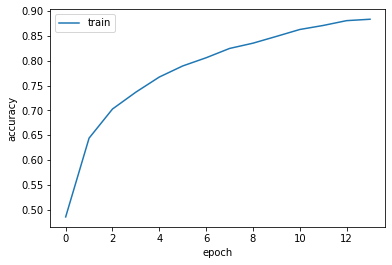

121/121 [==============================] - 1s 4ms/step - loss: 0.8396 - accuracy: 0.7809
Validation accuracy: 0.7808610200881958


In [39]:
VGG3().train(
    batch_size=128,
    epochs=20,
    optimizer=Adam(
        learning_rate=ExponentialDecay(
            initial_learning_rate=2e-3,
            decay_steps=1000,
            decay_rate=0.9)))

Epoch 1/10
1565/1565 [==============================] - 24s 11ms/step - loss: 1.5311 - accuracy: 0.5009
Epoch 2/10
1565/1565 [==============================] - 18s 11ms/step - loss: 1.0676 - accuracy: 0.6545
Epoch 3/10
1565/1565 [==============================] - 19s 12ms/step - loss: 0.9072 - accuracy: 0.7083
Epoch 4/10
1565/1565 [==============================] - 18s 11ms/step - loss: 0.8049 - accuracy: 0.7412
Epoch 5/10
1565/1565 [==============================] - 20s 13ms/step - loss: 0.7219 - accuracy: 0.7677
Epoch 6/10
1565/1565 [==============================] - 19s 12ms/step - loss: 0.6629 - accuracy: 0.7851
Epoch 7/10
1565/1565 [==============================] - 18s 11ms/step - loss: 0.6164 - accuracy: 0.7991
Timed stopping at epoch 7 after training for 0:02:00


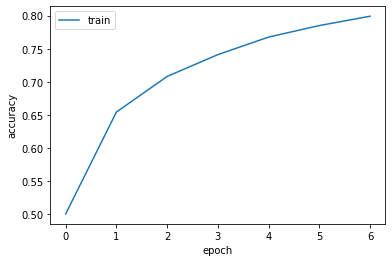

121/121 [==============================] - 1s 5ms/step - loss: 0.7263 - accuracy: 0.7762
Validation accuracy: 0.7761929631233215


In [40]:
VGG3().train(
    batch_size=32,
    epochs=10,
    optimizer=Adam(learning_rate=2e-3))

Epoch 1/20
392/392 [==============================] - 14s 22ms/step - loss: 1.6124 - accuracy: 0.4846
Epoch 2/20
392/392 [==============================] - 9s 22ms/step - loss: 1.0812 - accuracy: 0.6460
Epoch 3/20
392/392 [==============================] - 8s 22ms/step - loss: 0.9160 - accuracy: 0.7033
Epoch 4/20
392/392 [==============================] - 9s 22ms/step - loss: 0.8071 - accuracy: 0.7390
Epoch 5/20
392/392 [==============================] - 9s 22ms/step - loss: 0.7327 - accuracy: 0.7640
Epoch 6/20
392/392 [==============================] - 9s 22ms/step - loss: 0.6621 - accuracy: 0.7839
Epoch 7/20
392/392 [==============================] - 9s 22ms/step - loss: 0.6012 - accuracy: 0.8037
Epoch 8/20
392/392 [==============================] - 8s 21ms/step - loss: 0.5578 - accuracy: 0.8178
Epoch 9/20
392/392 [==============================] - 9s 22ms/step - loss: 0.5193 - accuracy: 0.8310
Epoch 10/20
392/392 [==============================] - 9s 22ms/step - loss: 0.4770 - accur

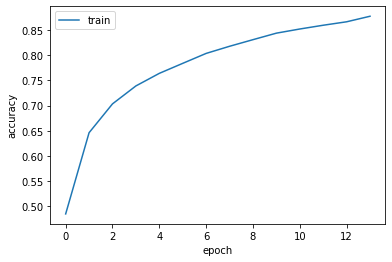

121/121 [==============================] - 1s 5ms/step - loss: 0.8318 - accuracy: 0.7881
Validation accuracy: 0.7881224155426025


In [41]:
VGG3().train(
    batch_size=128,
    epochs=20,
    optimizer=Adam(learning_rate=2e-3))

Epoch 1/20
783/783 [==============================] - 19s 14ms/step - loss: 1.5945 - accuracy: 0.4847
Epoch 2/20
783/783 [==============================] - 11s 14ms/step - loss: 1.0839 - accuracy: 0.6464
Epoch 3/20
783/783 [==============================] - 12s 15ms/step - loss: 0.9250 - accuracy: 0.7006
Epoch 4/20
783/783 [==============================] - 11s 14ms/step - loss: 0.8178 - accuracy: 0.7365
Epoch 5/20
783/783 [==============================] - 11s 14ms/step - loss: 0.7357 - accuracy: 0.7628
Epoch 6/20
783/783 [==============================] - 11s 14ms/step - loss: 0.6640 - accuracy: 0.7842
Epoch 7/20
783/783 [==============================] - 11s 14ms/step - loss: 0.6123 - accuracy: 0.8031
Epoch 8/20
783/783 [==============================] - 11s 14ms/step - loss: 0.5675 - accuracy: 0.8155
Epoch 9/20
783/783 [==============================] - 11s 14ms/step - loss: 0.5250 - accuracy: 0.8283
Epoch 10/20
783/783 [==============================] - 11s 14ms/step - loss: 0.482

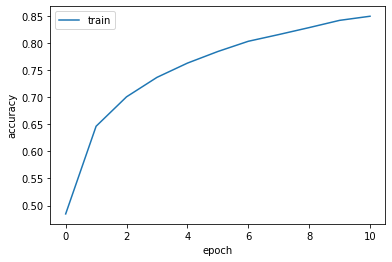

121/121 [==============================] - 1s 5ms/step - loss: 0.8907 - accuracy: 0.7464
Validation accuracy: 0.7463693022727966


In [56]:
VGG3().train(
    batch_size=64,
    epochs=20,
    optimizer=Adam(learning_rate=1.5e-3))

Epoch 1/30
196/196 [==============================] - 13s 41ms/step - loss: 1.7155 - accuracy: 0.4546
Epoch 2/30
196/196 [==============================] - 8s 38ms/step - loss: 1.1262 - accuracy: 0.6325
Epoch 3/30
196/196 [==============================] - 8s 39ms/step - loss: 0.9498 - accuracy: 0.6892
Epoch 4/30
196/196 [==============================] - 8s 39ms/step - loss: 0.8401 - accuracy: 0.7276
Epoch 5/30
196/196 [==============================] - 8s 39ms/step - loss: 0.7639 - accuracy: 0.7517
Epoch 6/30
196/196 [==============================] - 8s 39ms/step - loss: 0.6893 - accuracy: 0.7743
Epoch 7/30
196/196 [==============================] - 8s 38ms/step - loss: 0.6343 - accuracy: 0.7943
Epoch 8/30
196/196 [==============================] - 8s 39ms/step - loss: 0.5779 - accuracy: 0.8124
Epoch 9/30
196/196 [==============================] - 8s 40ms/step - loss: 0.5414 - accuracy: 0.8218
Epoch 10/30
196/196 [==============================] - 8s 39ms/step - loss: 0.4944 - accur

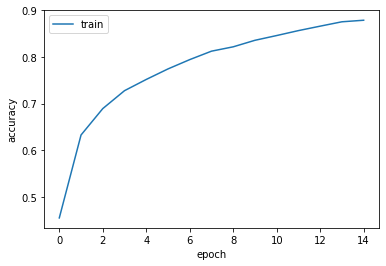

121/121 [==============================] - 1s 4ms/step - loss: 0.8464 - accuracy: 0.7816
Validation accuracy: 0.7816389799118042


In [57]:
VGG3().train(
    batch_size=256,
    epochs=30,
    optimizer=Adam(learning_rate=2e-3))

Epoch 1/30
196/196 [==============================] - 13s 39ms/step - loss: 1.6993 - accuracy: 0.4585
Epoch 2/30
196/196 [==============================] - 8s 41ms/step - loss: 1.1330 - accuracy: 0.6298
Epoch 3/30
196/196 [==============================] - 8s 39ms/step - loss: 0.9525 - accuracy: 0.6896
Epoch 4/30
196/196 [==============================] - 8s 39ms/step - loss: 0.8389 - accuracy: 0.7249
Epoch 5/30
196/196 [==============================] - 8s 39ms/step - loss: 0.7572 - accuracy: 0.7546
Epoch 6/30
196/196 [==============================] - 8s 39ms/step - loss: 0.6883 - accuracy: 0.7771
Epoch 7/30
196/196 [==============================] - 8s 38ms/step - loss: 0.6221 - accuracy: 0.7976
Epoch 8/30
196/196 [==============================] - 8s 39ms/step - loss: 0.5721 - accuracy: 0.8123
Epoch 9/30
196/196 [==============================] - 8s 40ms/step - loss: 0.5345 - accuracy: 0.8246
Epoch 10/30
196/196 [==============================] - 8s 39ms/step - loss: 0.4882 - accur

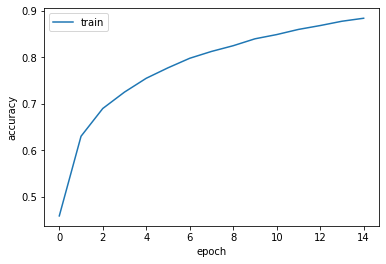

121/121 [==============================] - 1s 5ms/step - loss: 0.8120 - accuracy: 0.7912
Validation accuracy: 0.7912344336509705


In [59]:
VGG3().train(
    batch_size=256,
    epochs=30,
    optimizer=Adam(
        learning_rate=ExponentialDecay(
            initial_learning_rate=2e-3,
            decay_steps=1000,
            decay_rate=0.9)))

Epoch 1/15
  6/196 [..............................] - ETA: 9s - loss: 3.1687 - accuracy: 0.1523

196/196 [==============================] - 13s 40ms/step - loss: 1.6664 - accuracy: 0.4642
Epoch 2/15
196/196 [==============================] - 8s 39ms/step - loss: 1.1430 - accuracy: 0.6271
Epoch 3/15
196/196 [==============================] - 8s 40ms/step - loss: 0.9679 - accuracy: 0.6834
Epoch 4/15
196/196 [==============================] - 8s 39ms/step - loss: 0.8534 - accuracy: 0.7225
Epoch 5/15
196/196 [==============================] - 8s 40ms/step - loss: 0.7855 - accuracy: 0.7474
Epoch 6/15
196/196 [==============================] - 8s 39ms/step - loss: 0.7038 - accuracy: 0.7722
Epoch 7/15
196/196 [==============================] - 8s 39ms/step - loss: 0.6357 - accuracy: 0.7922
Epoch 8/15
196/196 [==============================] - 8s 39ms/step - loss: 0.5851 - accuracy: 0.8097
Epoch 9/15
196/196 [==============================] - 8s 39ms/step - loss: 0.5381 - accuracy: 0.8244
Epoch 10/15
196/196 [==============================] - 8s 40ms/step - loss: 0.5022 - accuracy: 0.8333

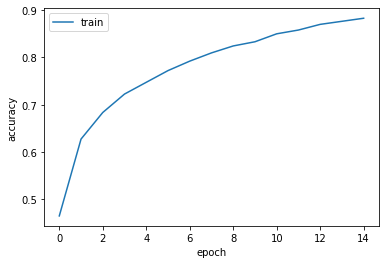

121/121 [==============================] - 1s 7ms/step - loss: 0.8516 - accuracy: 0.7835
Validation accuracy: 0.7834543585777283


In [77]:
# Again? Are you really the best by far?
VGG3().train(
    batch_size=256,
    epochs=15,
    optimizer=Adam(
        learning_rate=ExponentialDecay(
            initial_learning_rate=2e-3,
            decay_steps=1000,
            decay_rate=0.9)))

Epoch 1/30
392/392 [==============================] - 14s 23ms/step - loss: 1.5921 - accuracy: 0.4854
Epoch 2/30
392/392 [==============================] - 9s 22ms/step - loss: 1.0595 - accuracy: 0.6540
Epoch 3/30
392/392 [==============================] - 8s 22ms/step - loss: 0.8893 - accuracy: 0.7114
Epoch 4/30
392/392 [==============================] - 9s 22ms/step - loss: 0.7745 - accuracy: 0.7504
Epoch 5/30
392/392 [==============================] - 9s 22ms/step - loss: 0.6875 - accuracy: 0.7762
Epoch 6/30
392/392 [==============================] - 10s 26ms/step - loss: 0.6168 - accuracy: 0.7992
Epoch 7/30
392/392 [==============================] - 9s 24ms/step - loss: 0.5594 - accuracy: 0.8150
Epoch 8/30
392/392 [==============================] - 9s 23ms/step - loss: 0.5016 - accuracy: 0.8344
Epoch 9/30
392/392 [==============================] - 9s 22ms/step - loss: 0.4606 - accuracy: 0.8472
Epoch 10/30
392/392 [==============================] - 9s 22ms/step - loss: 0.4211 - accu

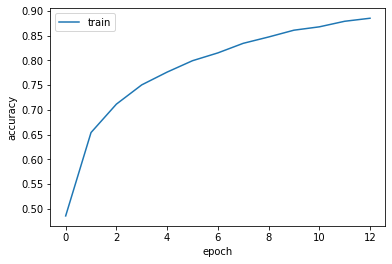

121/121 [==============================] - 1s 6ms/step - loss: 0.7813 - accuracy: 0.7837
Validation accuracy: 0.783713698387146


In [60]:
VGG3().train(
    batch_size=128,
    epochs=30,
    optimizer=Adam(
        learning_rate=ExponentialDecay(
            initial_learning_rate=2.5e-3,
            decay_steps=1000,
            decay_rate=0.6)))

Epoch 1/20
1565/1565 [==============================] - 28s 14ms/step - loss: 1.5143 - accuracy: 0.5041
Epoch 2/20
1565/1565 [==============================] - 21s 13ms/step - loss: 1.0598 - accuracy: 0.6574
Epoch 3/20
1565/1565 [==============================] - 20s 13ms/step - loss: 0.9122 - accuracy: 0.7079
Epoch 4/20
1565/1565 [==============================] - 23s 15ms/step - loss: 0.8126 - accuracy: 0.7389
Epoch 5/20
1565/1565 [==============================] - 17s 11ms/step - loss: 0.7269 - accuracy: 0.7676
Epoch 6/20
1565/1565 [==============================] - 18s 12ms/step - loss: 0.6613 - accuracy: 0.7871
Timed stopping at epoch 6 after training for 0:02:00


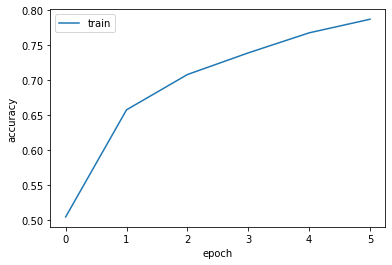

121/121 [==============================] - 1s 4ms/step - loss: 0.8462 - accuracy: 0.7342
Validation accuracy: 0.7341805100440979


In [61]:
VGG3().train(
    batch_size=32,
    epochs=20,
    optimizer=Adam(learning_rate=2e-3))

Epoch 1/30
196/196 [==============================] - 15s 41ms/step - loss: 1.6490 - accuracy: 0.4684
Epoch 2/30
196/196 [==============================] - 8s 43ms/step - loss: 1.1143 - accuracy: 0.6352
Epoch 3/30
196/196 [==============================] - 8s 38ms/step - loss: 0.9344 - accuracy: 0.6949
Epoch 4/30
196/196 [==============================] - 8s 40ms/step - loss: 0.8336 - accuracy: 0.7295
Epoch 5/30
196/196 [==============================] - 8s 38ms/step - loss: 0.7468 - accuracy: 0.7577
Epoch 6/30
196/196 [==============================] - 8s 40ms/step - loss: 0.6763 - accuracy: 0.7815
Epoch 7/30
196/196 [==============================] - 8s 39ms/step - loss: 0.6167 - accuracy: 0.7993
Epoch 8/30
196/196 [==============================] - 8s 39ms/step - loss: 0.5563 - accuracy: 0.8181
Epoch 9/30
196/196 [==============================] - 8s 39ms/step - loss: 0.5067 - accuracy: 0.8338
Epoch 10/30
196/196 [==============================] - 8s 39ms/step - loss: 0.4677 - accur

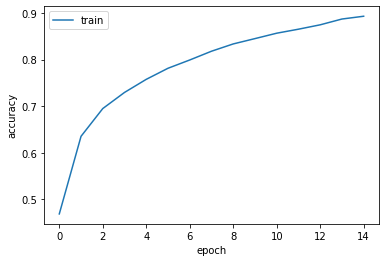

121/121 [==============================] - 1s 6ms/step - loss: 0.8462 - accuracy: 0.7814
Validation accuracy: 0.7813796401023865


In [66]:
VGG3().train(
    batch_size=256,
    epochs=30,
    optimizer=Adam(
        learning_rate=ExponentialDecay(
            initial_learning_rate=2.5e-3,
            decay_steps=1000,
            decay_rate=0.6)))

Epoch 1/30
196/196 [==============================] - 14s 39ms/step - loss: 1.7053 - accuracy: 0.4577
Epoch 2/30
196/196 [==============================] - 8s 42ms/step - loss: 1.1327 - accuracy: 0.6284
Epoch 3/30
196/196 [==============================] - 8s 40ms/step - loss: 0.9671 - accuracy: 0.6839
Epoch 4/30
196/196 [==============================] - 8s 39ms/step - loss: 0.8631 - accuracy: 0.7195
Epoch 5/30
196/196 [==============================] - 8s 39ms/step - loss: 0.7720 - accuracy: 0.7479
Epoch 6/30
196/196 [==============================] - 8s 39ms/step - loss: 0.7016 - accuracy: 0.7714
Epoch 7/30
196/196 [==============================] - 8s 39ms/step - loss: 0.6463 - accuracy: 0.7881
Epoch 8/30
196/196 [==============================] - 7s 38ms/step - loss: 0.5903 - accuracy: 0.8059
Epoch 9/30
196/196 [==============================] - 8s 39ms/step - loss: 0.5434 - accuracy: 0.8216
Epoch 10/30
196/196 [==============================] - 8s 43ms/step - loss: 0.4990 - accur

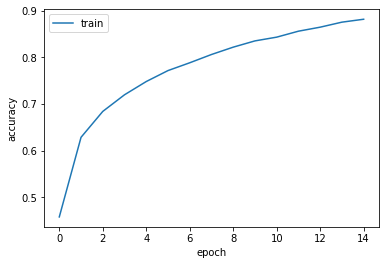

121/121 [==============================] - 1s 5ms/step - loss: 0.8019 - accuracy: 0.7759
Validation accuracy: 0.7759336233139038


In [67]:
VGG3().train(
    batch_size=256,
    epochs=30,
    optimizer=Adam(
        learning_rate=ExponentialDecay(
            initial_learning_rate=2e-3,
            decay_steps=1000,
            decay_rate=0.6)))

Epoch 1/30
196/196 [==============================] - 14s 45ms/step - loss: 1.7096 - accuracy: 0.4607
Epoch 2/30
196/196 [==============================] - 8s 42ms/step - loss: 1.1307 - accuracy: 0.6303
Epoch 3/30
196/196 [==============================] - 7s 38ms/step - loss: 0.9529 - accuracy: 0.6903
Epoch 4/30
196/196 [==============================] - 8s 39ms/step - loss: 0.8384 - accuracy: 0.7270
Epoch 5/30
196/196 [==============================] - 7s 38ms/step - loss: 0.7493 - accuracy: 0.7561
Epoch 6/30
196/196 [==============================] - 8s 40ms/step - loss: 0.6772 - accuracy: 0.7792
Epoch 7/30
196/196 [==============================] - 8s 38ms/step - loss: 0.6184 - accuracy: 0.7975
Epoch 8/30
196/196 [==============================] - 8s 39ms/step - loss: 0.5655 - accuracy: 0.8141
Epoch 9/30
196/196 [==============================] - 8s 39ms/step - loss: 0.5173 - accuracy: 0.8283
Epoch 10/30
196/196 [==============================] - 8s 39ms/step - loss: 0.4825 - accur

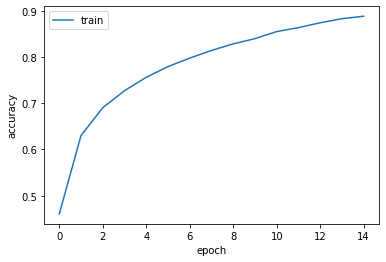

121/121 [==============================] - 1s 4ms/step - loss: 0.7927 - accuracy: 0.7863
Validation accuracy: 0.7863070368766785


In [68]:
VGG3().train(
    batch_size=256,
    epochs=30,
    optimizer=Adam(
        learning_rate=ExponentialDecay(
            initial_learning_rate=2e-3,
            decay_steps=1000,
            decay_rate=0.8)))

Epoch 1/30
 6/49 [==>...........................] - ETA: 6s - loss: 2.9778 - accuracy: 0.1938

49/49 [==============================] - 15s 169ms/step - loss: 2.0048 - accuracy: 0.3769
Epoch 2/30
49/49 [==============================] - 7s 140ms/step - loss: 1.3689 - accuracy: 0.5560
Epoch 3/30
49/49 [==============================] - 7s 140ms/step - loss: 1.1524 - accuracy: 0.6231
Epoch 4/30
49/49 [==============================] - 7s 140ms/step - loss: 1.0246 - accuracy: 0.6654
Epoch 5/30
49/49 [==============================] - 7s 139ms/step - loss: 0.9391 - accuracy: 0.6955
Epoch 6/30
49/49 [==============================] - 7s 141ms/step - loss: 0.8750 - accuracy: 0.7144
Epoch 7/30
49/49 [==============================] - 7s 138ms/step - loss: 0.8066 - accuracy: 0.7360
Epoch 8/30
49/49 [==============================] - 7s 140ms/step - loss: 0.7537 - accuracy: 0.7539
Epoch 9/30
49/49 [==============================] - 7s 138ms/step - loss: 0.7103 - accuracy: 0.7657
Epoch 10/30
49/49 [==============================] - 7s 140ms/step - loss: 0.6642 - accuracy: 0.7827
Epoch 11/

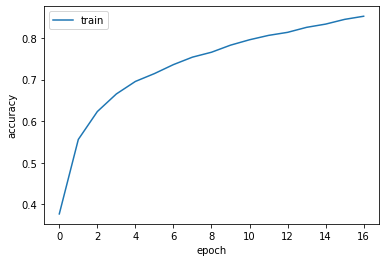

121/121 [==============================] - 1s 5ms/step - loss: 0.9815 - accuracy: 0.7311
Validation accuracy: 0.73106849193573


In [69]:
VGG3().train(
    batch_size=1024,
    epochs=30,
    optimizer=Adam(
        learning_rate=ExponentialDecay(
            initial_learning_rate=2e-3,
            decay_steps=1000,
            decay_rate=0.6)))

Epoch 1/30
 6/49 [==>...........................] - ETA: 6s - loss: 3.0008 - accuracy: 0.1818

49/49 [==============================] - 12s 139ms/step - loss: 2.0069 - accuracy: 0.3750
Epoch 2/30
49/49 [==============================] - 7s 139ms/step - loss: 1.3932 - accuracy: 0.5492
Epoch 3/30
49/49 [==============================] - 7s 140ms/step - loss: 1.1581 - accuracy: 0.6233
Epoch 4/30
49/49 [==============================] - 7s 141ms/step - loss: 1.0265 - accuracy: 0.6635
Epoch 5/30
49/49 [==============================] - 7s 141ms/step - loss: 0.9288 - accuracy: 0.6947
Epoch 6/30
49/49 [==============================] - 7s 141ms/step - loss: 0.8575 - accuracy: 0.7204
Epoch 7/30
49/49 [==============================] - 7s 144ms/step - loss: 0.8005 - accuracy: 0.7399
Epoch 8/30
49/49 [==============================] - 7s 142ms/step - loss: 0.7420 - accuracy: 0.7569
Epoch 9/30
49/49 [==============================] - 7s 144ms/step - loss: 0.6943 - accuracy: 0.7717
Epoch 10/30
49/49 [==============================] - 7s 142ms/step - loss: 0.6546 - accuracy: 0.7852
Epoch 11/

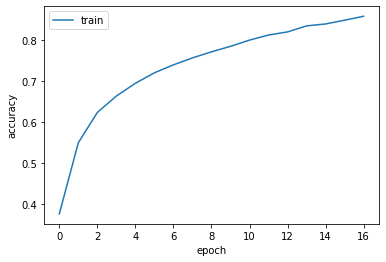

121/121 [==============================] - 1s 6ms/step - loss: 0.8199 - accuracy: 0.7713
Validation accuracy: 0.7712655663490295


In [71]:
VGG3().train(
    batch_size=1024,
    epochs=30,
    optimizer=Adam(
        learning_rate=ExponentialDecay(
            initial_learning_rate=2e-3,
            decay_steps=1000,
            decay_rate=0.9)))

Epoch 1/30
98/98 [==============================] - 15s 81ms/step - loss: 1.8515 - accuracy: 0.4173
Epoch 2/30
98/98 [==============================] - 7s 73ms/step - loss: 1.2365 - accuracy: 0.5975
Epoch 3/30
98/98 [==============================] - 7s 73ms/step - loss: 1.0282 - accuracy: 0.6637
Epoch 4/30
98/98 [==============================] - 7s 73ms/step - loss: 0.9043 - accuracy: 0.7067
Epoch 5/30
98/98 [==============================] - 7s 73ms/step - loss: 0.8243 - accuracy: 0.7319
Epoch 6/30
98/98 [==============================] - 7s 73ms/step - loss: 0.7517 - accuracy: 0.7561
Epoch 7/30
98/98 [==============================] - 7s 72ms/step - loss: 0.6816 - accuracy: 0.7774
Epoch 8/30
98/98 [==============================] - 7s 73ms/step - loss: 0.6368 - accuracy: 0.7908
Epoch 9/30
98/98 [==============================] - 7s 72ms/step - loss: 0.5851 - accuracy: 0.8090
Epoch 10/30
98/98 [==============================] - 7s 73ms/step - loss: 0.5453 - accuracy: 0.8216
Epoch 11

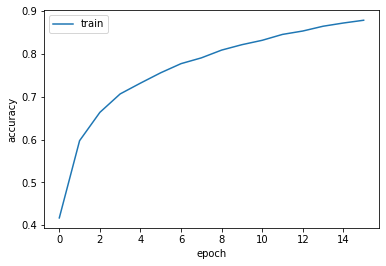

121/121 [==============================] - 1s 6ms/step - loss: 0.9522 - accuracy: 0.7500
Validation accuracy: 0.75


In [70]:
VGG3().train(
    batch_size=512,
    epochs=30,
    optimizer=Adam(
        learning_rate=ExponentialDecay(
            initial_learning_rate=2e-3,
            decay_steps=1000,
            decay_rate=0.9)))

Epoch 1/30
  5/196 [..............................] - ETA: 9s - loss: 3.2862 - accuracy: 0.1508

196/196 [==============================] - 13s 39ms/step - loss: 1.7187 - accuracy: 0.4518
Epoch 2/30
196/196 [==============================] - 7s 38ms/step - loss: 1.1297 - accuracy: 0.6296
Epoch 3/30
196/196 [==============================] - 8s 39ms/step - loss: 0.9648 - accuracy: 0.6834
Epoch 4/30
196/196 [==============================] - 8s 39ms/step - loss: 0.8488 - accuracy: 0.7244
Epoch 5/30
196/196 [==============================] - 8s 39ms/step - loss: 0.7657 - accuracy: 0.7522
Epoch 6/30
196/196 [==============================] - 8s 39ms/step - loss: 0.6996 - accuracy: 0.7746
Epoch 7/30
196/196 [==============================] - 8s 38ms/step - loss: 0.6416 - accuracy: 0.7895
Epoch 8/30
196/196 [==============================] - 8s 39ms/step - loss: 0.5790 - accuracy: 0.8114
Epoch 9/30
196/196 [==============================] - 7s 38ms/step - loss: 0.5358 - accuracy: 0.8229
Epoch 10/30
196/196 [==============================] - 8s 39ms/step - loss: 0.4962 - accuracy: 0.8372

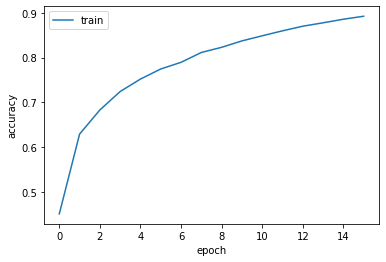

121/121 [==============================] - 1s 6ms/step - loss: 0.9169 - accuracy: 0.7658
Validation accuracy: 0.7658194899559021


In [72]:
VGG3().train(
    batch_size=256,
    epochs=30,
    optimizer=Adam(
        learning_rate=ExponentialDecay(
            initial_learning_rate=2e-3,
            decay_steps=1000,
            decay_rate=0.8)))

Epoch 1/30
  6/196 [..............................] - ETA: 8s - loss: 3.2212 - accuracy: 0.1530

196/196 [==============================] - 12s 39ms/step - loss: 1.7223 - accuracy: 0.4441
Epoch 2/30
196/196 [==============================] - 8s 38ms/step - loss: 1.1427 - accuracy: 0.6266
Epoch 3/30
196/196 [==============================] - 8s 39ms/step - loss: 0.9656 - accuracy: 0.6843
Epoch 4/30
196/196 [==============================] - 8s 38ms/step - loss: 0.8521 - accuracy: 0.7249
Epoch 5/30
196/196 [==============================] - 8s 39ms/step - loss: 0.7548 - accuracy: 0.7549
Epoch 6/30
196/196 [==============================] - 8s 39ms/step - loss: 0.6848 - accuracy: 0.7776
Epoch 7/30
196/196 [==============================] - 8s 39ms/step - loss: 0.6285 - accuracy: 0.7949
Epoch 8/30
196/196 [==============================] - 8s 39ms/step - loss: 0.5749 - accuracy: 0.8117
Epoch 9/30
196/196 [==============================] - 8s 39ms/step - loss: 0.5252 - accuracy: 0.8277
Epoch 10/30
196/196 [==============================] - 8s 39ms/step - loss: 0.4885 - accuracy: 0.8388

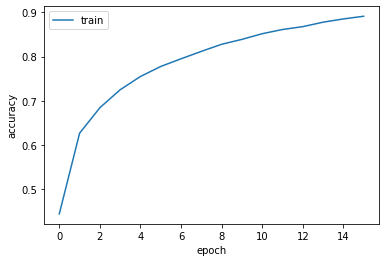

121/121 [==============================] - 1s 5ms/step - loss: 0.9744 - accuracy: 0.7617
Validation accuracy: 0.7616701126098633


In [73]:
VGG3().train(
    batch_size=256,
    epochs=30,
    optimizer=Adam(
        learning_rate=ExponentialDecay(
            initial_learning_rate=2e-3,
            decay_steps=1000,
            decay_rate=0.95)))

## ResNet9
https://www.kaggle.com/code/kmldas/cifar10-resnet-90-accuracy-less-than-5-min

### Architecture

In [42]:
class ResNet9(ImageClassificationBase):
  def __init__(self, in_channels=3, num_classes=10):
    super().__init__()
    
    self.conv1 = conv_block(in_channels, 64)
    self.conv2 = conv_block(64, 128, pool=True)
    self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
    
    self.conv3 = conv_block(128, 256, pool=True)
    self.conv4 = conv_block(256, 512, pool=True)
    self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
    
    self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                    nn.Flatten(), 
                                    nn.Linear(512, num_classes))

  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.classifier(out)
    return out

### Grid search

In [43]:
train_pytorch(ResNet9(),
              max_lr=1e-2,
              grad_clip=0.1,
              train_split=1,
              batch_size=400,
              weight_decay=1e-4,
              opt_func=torch.optim.Adam)

Time elapsed: 0.00047898292541503906
Epoch 1, last_lr: 0.00043, train_loss: 1.1527, val_loss: 0.9066, val_acc: 0.6981
Time elapsed: 30.555488348007202
Epoch 2, last_lr: 0.00050, train_loss: 0.6927, val_loss: 0.7659, val_acc: 0.7458
Time elapsed: 61.05180740356445
Epoch 3, last_lr: 0.00063, train_loss: 0.4930, val_loss: 0.4062, val_acc: 0.8706
Time elapsed: 91.43520832061768
Train accuracy: 0.8710913062095642
**Test accuracy: 0.7288780212402344


In [44]:
train_pytorch(ResNet9(),
              max_lr=1e-2,
              grad_clip=0.2,
              train_split=1,
              batch_size=400,
              weight_decay=1e-4,
              opt_func=torch.optim.Adam)

Time elapsed: 0.01177358627319336
Epoch 1, last_lr: 0.00043, train_loss: 1.1340, val_loss: 0.9149, val_acc: 0.6959
Time elapsed: 30.197205066680908
Epoch 2, last_lr: 0.00050, train_loss: 0.6866, val_loss: 0.6861, val_acc: 0.7685
Time elapsed: 60.54952883720398
Epoch 3, last_lr: 0.00063, train_loss: 0.4948, val_loss: 0.5917, val_acc: 0.7954
Time elapsed: 91.06581211090088
Train accuracy: 0.7960664629936218
**Test accuracy: 0.6846097707748413


In [45]:
train_pytorch(ResNet9(),
              max_lr=5e-3,
              grad_clip=0.1,
              train_split=1,
              batch_size=400,
              weight_decay=1e-4,
              opt_func=torch.optim.Adam)

Time elapsed: 0.012573957443237305
Epoch 1, last_lr: 0.00021, train_loss: 1.1466, val_loss: 0.9686, val_acc: 0.6756
Time elapsed: 30.305917739868164
Epoch 2, last_lr: 0.00025, train_loss: 0.6910, val_loss: 0.6620, val_acc: 0.7818
Time elapsed: 60.8755669593811
Epoch 3, last_lr: 0.00032, train_loss: 0.4614, val_loss: 0.4159, val_acc: 0.8753
Time elapsed: 91.38774156570435
Train accuracy: 0.8757192492485046
**Test accuracy: 0.7105792760848999


In [46]:
train_pytorch(ResNet9(),
              max_lr=5e-3,
              grad_clip=0.2,
              train_split=1,
              batch_size=400,
              weight_decay=1e-4,
              opt_func=torch.optim.Adam)

Time elapsed: 0.01664257049560547
Epoch 1, last_lr: 0.00021, train_loss: 1.1434, val_loss: 0.8869, val_acc: 0.7048
Time elapsed: 30.578349828720093
Epoch 2, last_lr: 0.00025, train_loss: 0.6851, val_loss: 0.5556, val_acc: 0.8160
Time elapsed: 61.05014371871948
Epoch 3, last_lr: 0.00032, train_loss: 0.4541, val_loss: 0.4128, val_acc: 0.8697
Time elapsed: 92.42756986618042
Train accuracy: 0.8701189756393433
**Test accuracy: 0.7158963084220886


In [48]:
train_pytorch(ResNet9(),
              max_lr=1e-2,
              grad_clip=0.1,
              train_split=1,
              batch_size=128,
              weight_decay=1e-4,
              opt_func=torch.optim.Adam)

Time elapsed: 0.0013339519500732422
Epoch 1, last_lr: 0.00043, train_loss: 1.0493, val_loss: 0.7523, val_acc: 0.7535
Time elapsed: 36.02117705345154
Epoch 2, last_lr: 0.00050, train_loss: 0.6354, val_loss: 0.6598, val_acc: 0.7746
Time elapsed: 70.41728901863098
Epoch 3, last_lr: 0.00063, train_loss: 0.4383, val_loss: 0.3141, val_acc: 0.9005
Time elapsed: 105.1156234741211
Train accuracy: 0.9002112746238708
**Test accuracy: 0.775146484375


In [58]:
train_pytorch(ResNet9(),
              max_lr=1.5e-2,
              grad_clip=0.1,
              train_split=1,
              batch_size=128,
              weight_decay=1e-4,
              opt_func=torch.optim.Adam)

Time elapsed: 0.02948141098022461
Epoch 1, last_lr: 0.00064, train_loss: 1.0647, val_loss: 0.8282, val_acc: 0.7256
Time elapsed: 35.47180461883545
Epoch 2, last_lr: 0.00076, train_loss: 0.6645, val_loss: 0.8467, val_acc: 0.7236
Time elapsed: 70.34753108024597
Epoch 3, last_lr: 0.00095, train_loss: 0.4682, val_loss: 0.4689, val_acc: 0.8411
Time elapsed: 104.5660228729248
Train accuracy: 0.8410993218421936
**Test accuracy: 0.74462890625


In [65]:
train_pytorch(ResNet9(),
              max_lr=1e-2,
              grad_clip=None,
              train_split=1,
              batch_size=128,
              weight_decay=0,
              opt_func=torch.optim.Adam)

Time elapsed: 0.004044771194458008
Epoch 1, last_lr: 0.00043, train_loss: 1.0477, val_loss: 0.9881, val_acc: 0.6838
Time elapsed: 34.34621071815491
Epoch 2, last_lr: 0.00050, train_loss: 0.6400, val_loss: 0.5886, val_acc: 0.8041
Time elapsed: 69.63753509521484
Epoch 3, last_lr: 0.00063, train_loss: 0.4321, val_loss: 0.4367, val_acc: 0.8465
Time elapsed: 103.7777328491211
Train accuracy: 0.8460817933082581
**Test accuracy: 0.720703125


# Moving Forward

https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras#multi-worker_configuration

https://arxiv.org/pdf/1409.1556.pdf

https://core.ac.uk/download/pdf/232931127.pdf

https://myrtle.ai/how-to-train-your-resnet-8-bag-of-tricks/